In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Importing the necessary packages below

In [2]:
import os
import numpy as np
import pandas as pd
import glob
from pickleshare import PickleShareDB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, SimpleRNN
from plot_keras_history import plot_history
from tensorflow.keras.layers import Bidirectional, LSTM, RepeatVector, Dense
import matplotlib.pyplot as plt
import datetime
import scikitplot as skplt

Importing the GloVeFil neccessary to create the embedding vectors. The set of code below loops through each line in inFile and parse out the word, which is the first value in each line, and creates an array for the rest of the line which is then set to the emIndx dictionary.

In [3]:
GloVeFil=r'C:\Users\jonah.muniz\OneDrive - Accenture\Masters Program\Practical Machine Learning\glove.6B\glove.6B.100d.txt'  # vector file
emIndx=dict()
with open(GloVeFil, encoding="utf8") as inFile:
    emFil=inFile.readlines()
cnt = 0
for line in emFil:      
    vals = line.split()
    word = vals[0] 
    coefs = np.asarray(vals[1:],dtype='float32')  
    emIndx[word]=coefs

In [4]:
print(f'number of vectors {len(emIndx)}')

number of vectors 400000


In [5]:
len(emFil[10].split())

101

Setting the same hyperparameters that were used in part 0 and part 1

In [49]:
maxWords=10000  
emDim=100   
maxLen=80  

Importing the wordIndx used to generate the train and val set of data in part0

In [7]:
db4=PickleShareDB(r'C:\Users\jonah.muniz\OneDrive - Accenture\Masters Program\Practical Machine Learning\assign4.pshare')
wordIndx=db4['wordIndx']   

In [8]:
type(wordIndx)
len(wordIndx)

dict

88582

Creating the embedding matrix below. The expected outcome is a numpy array with 10000 words and 100 embedding dimensions

In [32]:
maxWords=10000
emDim=100
emMat=np.zeros((maxWords,emDim))   
for word, i in wordIndx.items():
    if i < maxWords:
        emVec = emIndx.get(word) 
        if emVec is not None:
            emMat[i]=emVec

In [10]:
type(emMat)
emMat.shape

numpy.ndarray

(10000, 100)

Saving the embedding matrix below

In [11]:
db4['emMat10000X100']=emMat

Creating the base model below to compare results to the subsequent RNN models

In [12]:
model = Sequential()
model.add(Embedding(maxWords,emDim,input_length=maxLen))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 100)           1000000   
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                512064    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,512,129
Trainable params: 1,512,129
Non-trainable params: 0
_________________________________________________________________


Setting the weights of the models layer equal to the embedding matrix and setting the training for that first layer to be false

In [14]:
model.layers[0].set_weights([emMat])  
model.layers[0].trainable=False       

In [1]:
# db4.keys()

Importing and setting data variables equal to their respective data sets for both autoencoded data sets and none autoencoded data sets

In [16]:
XTrain=db4['XTrain']
yTrain=db4['yTrain']
XVal=db4['XVal']
yVal=db4['yVal']
XTest = db4['XTest']
yTest = db4['yTest']
XTrainEm = db4['XTrainEm']
XValEm = db4['XValEm']
XTestEm = db4['XTestEm']
yTrainEm = db4['yTrainEm']
yValEm = db4['yValEm']
yTestEm = db4['yTestEm']

## Base Model
Compiling the model and running the model below. Using rmsprop as the optimizer, binary_crossentropy as the loss due to this task being a binary classifier and accuracy as the metric. Using a batch size of 32 as the defualt and only 10 epochs.

In [21]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [22]:
history=model.fit(XTrain, yTrain,
        epochs=10,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0)
model.save_weights('assign-4-pretrained-test-1.h5')

Plotting both the training and validation loss and accuracy for the model above to determine if the model is overfitting

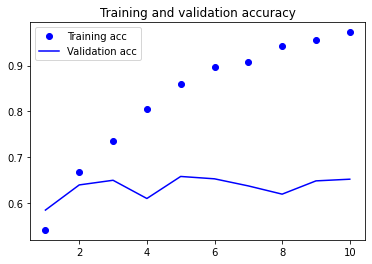

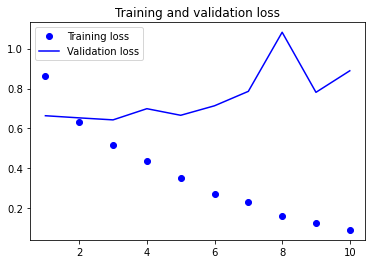

In [23]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show();

In [24]:
resDF=pd.DataFrame(history.history)
print(resDF[['acc','val_acc','loss','val_loss']])

      acc   val_acc      loss  val_loss
0  0.5410  0.584333  0.862768  0.663855
1  0.6675  0.639333  0.634744  0.653103
2  0.7350  0.649500  0.518593  0.643074
3  0.8045  0.609667  0.437029  0.699126
4  0.8605  0.657833  0.351986  0.666050
5  0.8980  0.652667  0.271695  0.713669
6  0.9070  0.637167  0.230164  0.786008
7  0.9435  0.619167  0.163622  1.082226
8  0.9560  0.648167  0.126245  0.781181
9  0.9730  0.651833  0.091621  0.889104


As can be seen in the plots and table above, the baseline model is clearly overfitting the training data.

Taking a quick look at the keys in the wordIndex, saving the results of the model, and clearing the session before the next model is defined, compiled and fitted.

In [25]:
[key for key in db4['wordIndx'].keys()][:12]

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that']

In [26]:
%load_ext tensorboard

In [27]:
log_dir=r'C:\Users\jonah.muniz\OneDrive - Accenture\Masters Program\Practical Machine Learning\run1'   # Explicit specification of dir for model results
tensorflow_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                  histogram_freq=1)

In [28]:
tf.keras.backend.clear_session()

Running model again this time saving the weights. Plotting the loss and accuracy for both train and validation.

In [29]:
history=model.fit(XTrain, yTrain,
        epochs=20,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0,
        callbacks=[tensorflow_callback])
model.save_weights('assign-4-pretrained-test-1.h5')

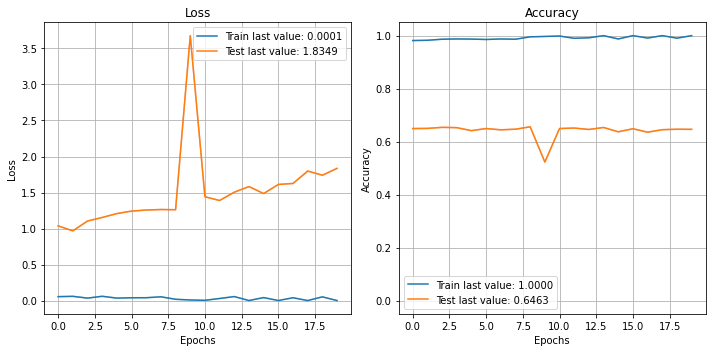

In [30]:
plot_history(history.history)   # this is from plot_keras_history

As can be seen above this model is dramatically overfitting the training data

## Simple Model With Embedding and Dropout Layers
Creating a simple model with an embedding layer, flatten layer, dropout layer, and two dense layer one using relu activation with 64 neurons and the other being an output layer using sigmoid as the activation. Again we are using the embedding matrix weights for the the layers and training is set to false for the embedding layer.

In [33]:
modeld1 = Sequential()
modeld1.add(Embedding(maxWords,emDim,input_length=maxLen))
modeld1.add(Flatten())
modeld1.add(Dropout(.2))
modeld1.add(Dense(64,activation='relu'))
modeld1.add(Dense(1,activation='sigmoid'))
modeld1.layers[0].set_weights([emMat])
modeld1.layers[0].trainable=False

In [34]:
modeld1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 100)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                512064    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,512,129
Trainable params: 512,129
Non-trainable params: 1,000,000
_________________________________________________________________


Compiling this model using the same hyperparameters as the base model to ensure we can compare the models performance to one another

In [35]:
modeld1.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [36]:
log_dir=r'C:\Users\jonah.muniz\OneDrive - Accenture\Masters Program\Practical Machine Learning\run2'
tensorflow_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                  histogram_freq=1)

Running the RNN with dropout and saving the weights. A plot of the train and validation accuracy and loss is produced below.

In [34]:
history=modeld1.fit(XTrain, yTrain,
        epochs=20,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0,
        callbacks=[tensorflow_callback])
model.save_weights('assign-4-dropout-pretrained-test-1.h5')

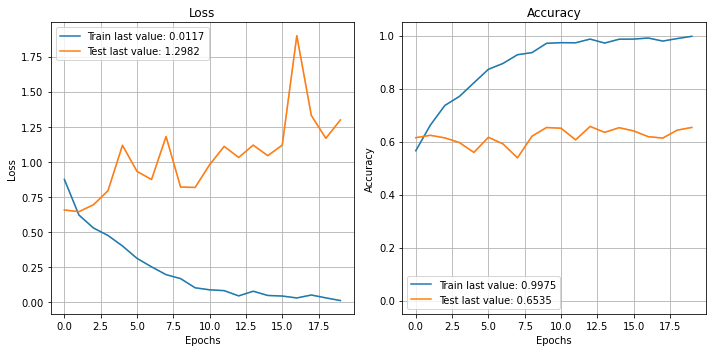

In [35]:
plot_history(history.history)   

As can be seen above, this model is dramatically overfitting the training data leading to a difference in 34% in accuracy from training to validation.

In [37]:
tf.keras.backend.clear_session()

## Simple RNN Model with Embedding Layer
Creating a simple RNN model with an embedding layer

In [38]:
modelRNN1=Sequential()
modelRNN1.add(Embedding(maxWords,emDim,input_length=maxLen))
modelRNN1.add(SimpleRNN(64,dropout=0.20, recurrent_dropout=0.20))
modelRNN1.add(Dense(1,activation='sigmoid'))
modelRNN1.layers[0].set_weights([emMat])
modelRNN1.layers[0].trainable=False

In [39]:
log_dir=r'C:\Users\jonah.muniz\OneDrive - Accenture\Masters Program\Practical Machine Learning\run3'
tensorflow_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                  histogram_freq=1)

Compiling the model using adam as the optizer, binary_crossentropy as the loss and accuracy as the metric

In [40]:
modelRNN1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc'],)

The model is fitted and the plot if loss and accuracy for both train and validation is produced below.The weights are saved as well.

In [40]:
history=modelRNN1.fit(XTrain, yTrain,
        epochs=20,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0,
        callbacks=[tensorflow_callback])
model.save_weights('assign-4-RNN1-pretrained-test-1.h5')

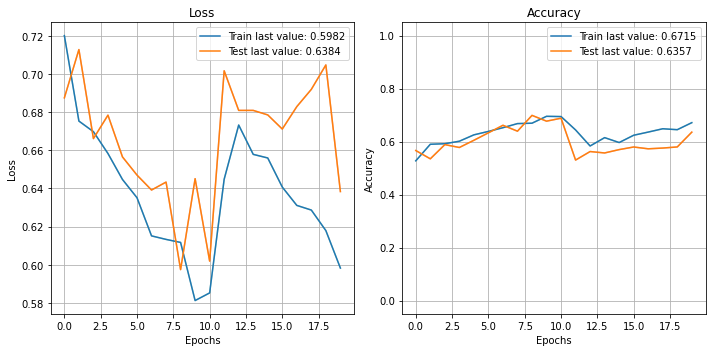

In [41]:
plot_history(history.history)   # this is from plot_keras_history

As can be seen in the two graphs above, the amount of overfitting that was shown in the previous model is no longer present. The accuracy is relatively low but the overfitting problem has been resolved. 

In [42]:
tf.keras.backend.clear_session()

## RNN Model with LSTM an Embedding Layer and recurrent_activation (Part A Model)

In [43]:
log_dir=r'C:\Users\jonah.muniz\OneDrive - Accenture\Masters Program\Practical Machine Learning\run4'

tensorflow_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                  histogram_freq=1)

In [44]:
modelLSTM1=Sequential()
modelLSTM1.add(Embedding(maxWords,emDim,input_length=maxLen))
modelLSTM1.add(LSTM(64,dropout=0.20, recurrent_dropout=0.20,
                    recurrent_activation='sigmoid'))
modelLSTM1.add(Dense(1,activation='sigmoid'))
modelLSTM1.layers[0].set_weights([emMat])
modelLSTM1.layers[0].trainable=False

In [45]:
modelLSTM1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 100)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,042,305
Trainable params: 42,305
Non-trainable params: 1,000,000
_________________________________________________________________


Compiling the RNN model using the same hyperparameters as the previous RNN model

In [46]:
modelLSTM1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [47]:
history=modelLSTM1.fit(XTrain, yTrain,
        epochs=20,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0,
        callbacks=[tensorflow_callback])
model.save_weights('assign-4-LSTM1-pretrained-test-1.h5')

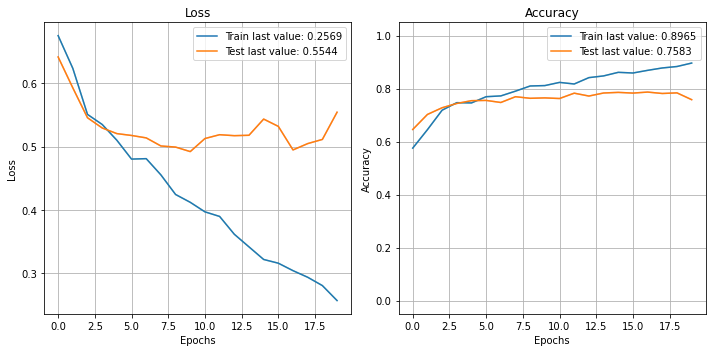

In [48]:
plot_history(history.history)  

As can be seen above, modelLSTM1 performed the best at classifying movie review sentiment across all the previous models. This model will be used to complete Part A and the test data loss and accuracy will be determined as well as a precision-recall curve, roc curve and confusion matrix.

In [49]:
score, acc = modelLSTM1.evaluate(XTest,yTest,verbose=0)

In [50]:
print(f'test data loss {score:0.4f}, test data accuracy {acc:0.4f}')

test data loss 0.5588, test data accuracy 0.7555


Predicting the test data using the model and XTest data

In [51]:
testProbs=modelLSTM1.predict(XTest)

In [52]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)

Comparing yTest data and the output of the model predictions. As can be seen the output of the model is a percentage.

In [53]:
yTest[:10]
testProbs[:10]

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0])

array([[0.34131217],
       [0.6892931 ],
       [0.6895388 ],
       [0.6979544 ],
       [0.4029501 ],
       [0.11677837],
       [0.8960488 ],
       [0.18929043],
       [0.9925605 ],
       [0.00106901]], dtype=float32)

Predicting the probabilites for two classes

In [54]:
probs2Classes=np.concatenate((1-testProbs,testProbs),axis=1)

probs2Classes[:8,]

array([[0.65868783, 0.34131217],
       [0.3107069 , 0.6892931 ],
       [0.31046122, 0.6895388 ],
       [0.30204558, 0.6979544 ],
       [0.5970499 , 0.4029501 ],
       [0.8832216 , 0.11677837],
       [0.10395122, 0.8960488 ],
       [0.8107096 , 0.18929043]], dtype=float32)

Using the yTest and probs2Classes data sets to create a precision recall curve and ROC Curve

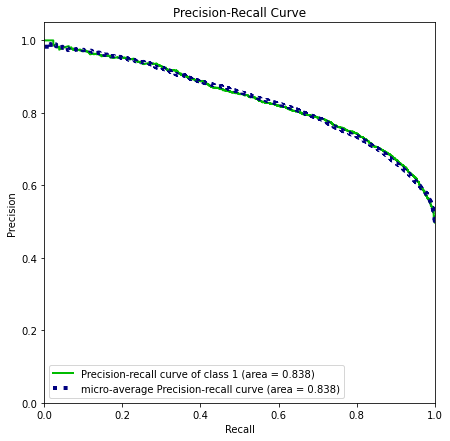

In [55]:
skplt.metrics.plot_precision_recall(yTest, probs2Classes,
                                         classes_to_plot=[1]);

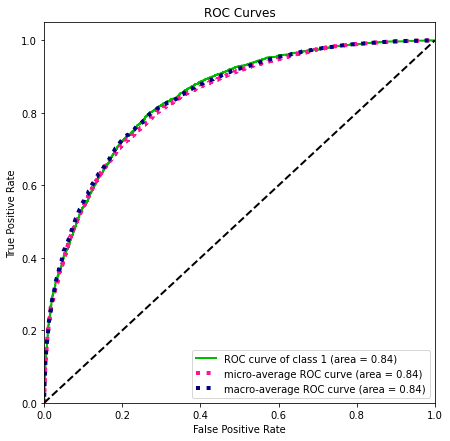

In [56]:
skplt.metrics.plot_roc(yTest,probs2Classes,classes_to_plot=[1]);

Creating a confusion matrix comparing the yTest and the testProbs data sets to understand TP,FP,TN and FN percentages.

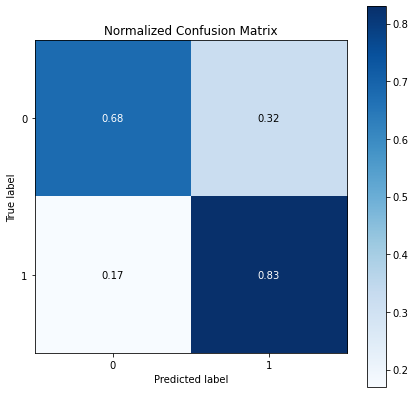

In [57]:
skplt.metrics.plot_confusion_matrix(yTest,(testProbs>0.50).astype(int), normalize=True);

## Training the best RNN Model with the autoencoder data (Part B Model)

Using the same model build as seen above in order to compare autoencoder embeddings performance to GloVeB6.100 

In [68]:
modelLSTM2=Sequential()
modelLSTM2.add(Embedding(maxWords,emDim,input_length=maxLen))
modelLSTM2.add(LSTM(64,dropout=0.20, recurrent_dropout=0.20,
                    recurrent_activation='sigmoid'))
modelLSTM2.add(Dense(1,activation='sigmoid'))
modelLSTM2.layers[0].set_weights([emMat])
modelLSTM2.layers[0].trainable=False

In [69]:
modelLSTM2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

Normalizing the autoencoder datasets to regularize the datasets

In [70]:
XTrainEmMod = (XTrainEm-XTrainEm.min())/(XTrainEm.max()-XTrainEm.min())
XValEmMod = (XValEm-XValEm.min())/(XValEm.max()-XValEm.min())
XTestEmMod = (XTestEm-XTestEm.min())/(XTestEm.max()-XTestEm.min())
maxWords = 2

In [71]:
history=modelLSTM2.fit(XTrainEmMod, yTrain,
        epochs=20,
        batch_size=32,
        validation_data=(XValEmMod,yVal),
        verbose=0,
        callbacks=[tensorflow_callback])
model.save_weights('assign-4-LSTM1-pretrained-test-2.h5')

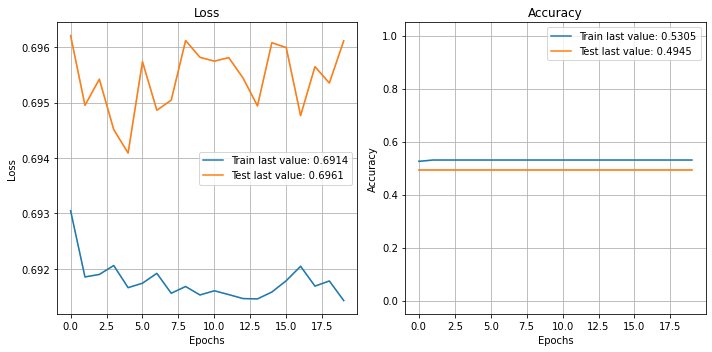

In [72]:
plot_history(history.history)  

As can be seen above in the loss and accuracy plots, the model using the autoencoded data sets is essentially a flip of a coin in terms of accuracy at classifying movie review sentiment for the training and validation dataset.

In [73]:
score, acc = modelLSTM2.evaluate(XTestEmMod,yTest,verbose=0)

In [74]:
print(f'test data loss {score:0.4f}, test data accuracy {acc:0.4f}')

test data loss 0.6961, test data accuracy 0.4943


Predicting the test data, comparing it to the yTest data set and creating two probability classes

In [56]:
testProbs=modelLSTM2.predict(XTest)

In [57]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)

In [58]:
yTest[:10]
testProbs[:10]

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0])

array([[0.59050024],
       [0.5673804 ],
       [0.61506   ],
       [0.5866453 ],
       [0.59612465],
       [0.56434256],
       [0.56394416],
       [0.65354085],
       [0.5427138 ],
       [0.616965  ]], dtype=float32)

In [59]:
probs2Classes=np.concatenate((1-testProbs,testProbs),axis=1)

probs2Classes[:8,]

array([[0.40949976, 0.59050024],
       [0.43261957, 0.5673804 ],
       [0.38494003, 0.61506   ],
       [0.4133547 , 0.5866453 ],
       [0.40387535, 0.59612465],
       [0.43565744, 0.56434256],
       [0.43605584, 0.56394416],
       [0.34645915, 0.65354085]], dtype=float32)

Plotting a precision recall curve, roc curve and confusion matrix

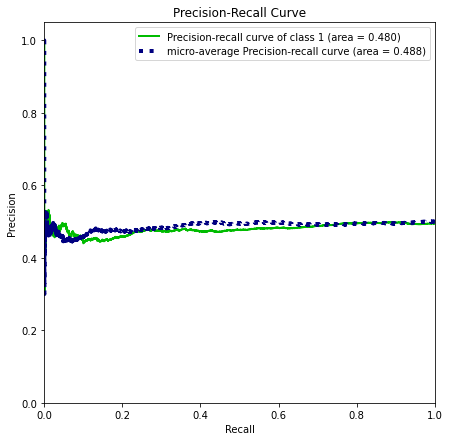

In [60]:
skplt.metrics.plot_precision_recall(yTest, probs2Classes,
                                         classes_to_plot=[1]);

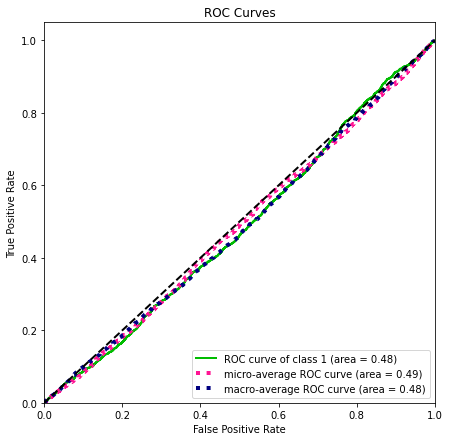

In [61]:
skplt.metrics.plot_roc(yTest,probs2Classes,classes_to_plot=[1]);

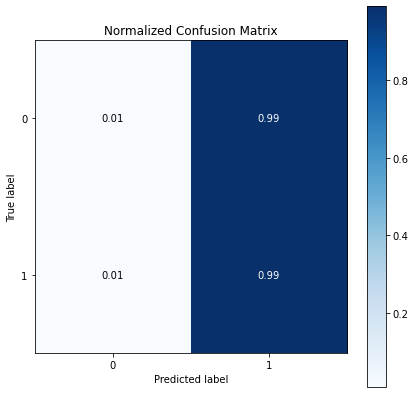

In [62]:
skplt.metrics.plot_confusion_matrix(yTest,(testProbs>0.50).astype(int), normalize=True);

Comparing the accruacy metrics from Part A and Part B you can clearly see that the RNN model performed the best when fitted with the GloVe6B.100 embeddings compared to the autoencoder embedding vectors. In Part A the RNN model was able to achieve 75.5% accuracy for the test data while Part B RNN model was only able to achieve 49.3% which is slightly lower than just flipping a coin.